# Bounce and Hit prediction

In this notebook two different models to predict bounces and hits in the balls positions are trained

### imports

In [1]:
import json
import pandas as pd
import numpy as np
from scipy.spatial import distance
from mpl_toolkits.axes_grid1 import make_axes_locatable
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from collections import Counter
from xgboost import plot_importance
from sklearn.utils import compute_sample_weight
from sklearn.preprocessing import StandardScaler
from sktime.classification.kernel_based import RocketClassifier
from imblearn.over_sampling import SMOTE
import wandb
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [ ]:
# read annotation json
with open('../00_Dataset/annotations_bounce.json') as f:
    data = json.load(f)

In [ ]:
for subset in data['subsets']:
    for video in subset['videos']:
        for clip in video['clips']:
            if video['name'] == 'Video_6' and clip['name'] == 'clip_1':
                for key, frame in clip['frames_with_objects'].items():
                    if len(frame['balls']) > 0:
                        if frame['balls'][0]['trajectory'] == 'Hit':
                            print(key, frame['balls'][0])

110 {'x': 808, 'y': 135, 'visibility': 'Visible', 'trajectory': 'Hit', 'id': '461'}
141 {'x': 526, 'y': 245, 'visibility': 'Difficult', 'trajectory': 'Hit', 'id': '461'}
219 {'x': 326, 'y': 264, 'visibility': 'Visible', 'trajectory': 'Hit', 'id': '461'}
261 {'x': 705, 'y': 244, 'visibility': 'Difficult', 'trajectory': 'Hit', 'id': '461'}


## visualization

In [78]:
# Define D3 Category 10 colors
d3_colors = [
    '#1f77b4',  # Blue
    '#ff7f0e',  # Orange
    '#2ca02c',  # Green
    '#d62728',  # Red
    '#9467bd',  # Purple
    '#8c564b',  # Brown
    '#e377c2',  # Pink
    '#7f7f7f',  # Gray
    '#bcbd22',  # Yellow-Green
    '#17becf'   # Cyan
]

# Set D3 colors as the default color cycle
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=d3_colors)


def set_plot_style_default():
    # General font settings
    plt.rcParams['font.family'] = 'Sans Serif'      # Use Ariel like overleaf
    plt.rcParams['font.size'] = 12             # Base font size for readability
    plt.rcParams['axes.titlesize'] = 14        # Larger title font size
    plt.rcParams['axes.labelsize'] = 12        # Label font size
    plt.rcParams['xtick.labelsize'] = 10       # X-tick font size
    plt.rcParams['ytick.labelsize'] = 10       # Y-tick font size
    plt.rcParams['legend.fontsize'] = 10       # Legend font size
    
    # Line and marker settings
    plt.rcParams['lines.linewidth'] = 1.5      # Make lines thicker for better visibility
    plt.rcParams['lines.markersize'] = 6       # Standard marker size
    
    # Axes and grid settings
    plt.rcParams['axes.grid'] = True           # Enable grid
    plt.rcParams['grid.linestyle'] = '--'      # Use dashed line for grid
    plt.rcParams['grid.alpha'] = 0.7           # Grid transparency
    plt.rcParams['axes.edgecolor'] = 'black'   # Black border around plot area
    plt.rcParams['axes.linewidth'] = 1         # Border line thickness

    # Ensure grid is below the plot elements
    plt.rcParams['axes.axisbelow'] = True          # Grid lines below plot elements

    # Legend settings
    plt.rcParams['legend.frameon'] = True      # Frame around the legend
    plt.rcParams['legend.framealpha'] = 0.9    # Slightly transparent legend background
    plt.rcParams['legend.loc'] = 'best'        # Automatically place legend in the best location

    # Tick direction
    plt.rcParams['xtick.direction'] = 'in'     # Inward tick direction for x-axis
    plt.rcParams['ytick.direction'] = 'in'     # Inward tick direction for y-axis


In [ ]:
# get video 6 clip 1
clip = data["subsets"][0]["videos"][5]["clips"][0]

ball_positions = []
hits = []
bounces = []
indexes = []
i = 0
# loop over frames
for frame, objects in clip["frames_with_objects"].items():
    if len(objects['balls']) > 0:
        ball_positions.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
        if objects['balls'][0]['trajectory'] == 'Hit':
            hits.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
            indexes.append(i)
        elif objects['balls'][0]['trajectory'] == 'Bounce':
            bounces.append((objects['balls'][0]['x'], objects['balls'][0]['y']))
            indexes.append(i)
    else:
        ball_positions.append((None, None))
    i += 1

print(hits)
print(bounces)
print(indexes)

[(808, 135), (526, 245), (326, 264), (705, 244)]
[(861, 510), (567, 312), (410, 390), (654, 305), (844, 334)]
[4, 110, 124, 141, 193, 219, 242, 261, 285]


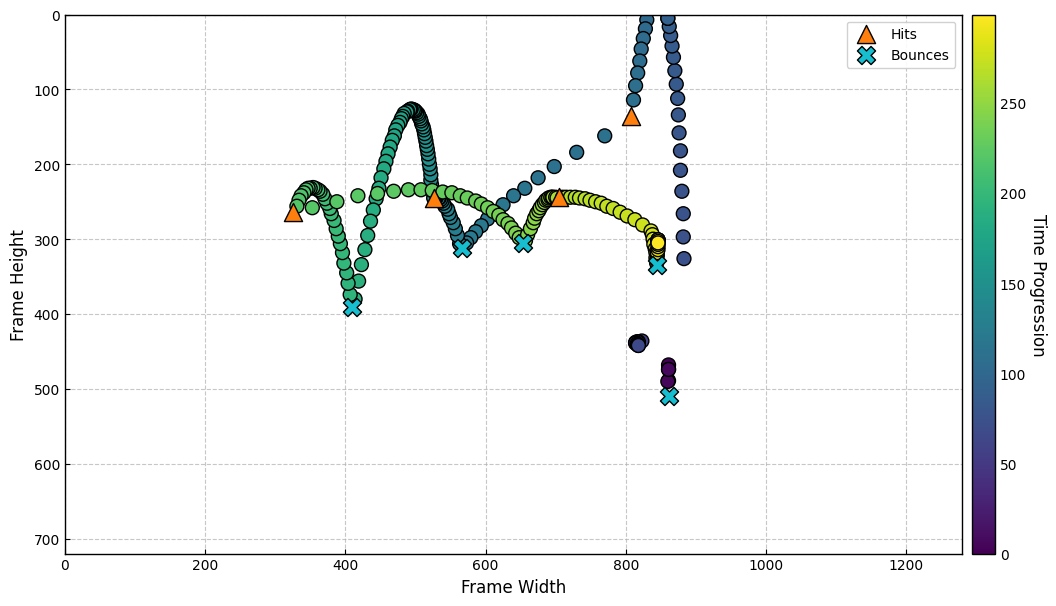

In [ ]:
set_plot_style_default()

# replace indexes with (None, None) 
ball_positions_filtered = ball_positions.copy()
for index in indexes:
    ball_positions_filtered[index] = (None, None)

# plot ball positions
ball_positions_filtered = np.array(ball_positions_filtered)
hits= np.array(hits)
bounces = np.array(bounces)

# Simulated time 
time = np.arange(len(ball_positions_filtered))  # Frames from 0 to length of ball_positions_filtered

# Create figure and axis
fig, ax = plt.subplots(figsize=(12, 7))

# Plot ball positions
scatter = ax.scatter(ball_positions_filtered[:, 0], ball_positions_filtered[:, 1], c=time, cmap='viridis', s=100, edgecolor='k')

# Add hits and bounces
if hits.size > 0:
    ax.scatter(hits[:, 0], hits[:, 1], color=d3_colors[1], label='Hits', marker='^', s=170, edgecolors='k')
if bounces.size > 0:
    ax.scatter(bounces[:, 0], bounces[:, 1], color=d3_colors[9], label='Bounces', marker='X', s=170, edgecolors='k')

# Adjust plot settings
ax.invert_yaxis()
ax.set_xlim(0, 1280)
ax.set_ylim(720, 0)
ax.set_xlabel("Frame Width")
ax.set_ylabel("Frame Height")
ax.legend()

# Add colorbar for time progression with adjusted position
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2.5%", pad=0.1)
cbar = fig.colorbar(scatter, cax=cax)
cbar.set_label("Time Progression", rotation=270, labelpad=15)

# Show plot
plt.show()


## bounce and hit prediction

In [9]:
def scale_points(point, scale):
    # scale and round to int
    return (int(point[0] * scale), int(point[1] * scale))

# read the data
def convert_json_to_df(json_data, split='train', resolution=[1280, 720], file_path='../FinalDataset/'):
    rows = []
    for subset in json_data['subsets']:
        resolution_subset= subset['resolution']
        if 'ball' in subset['objects']:
            for video in subset['videos']:
                for clip in video['clips']:
                    for frame_number, frame in clip['frames_with_objects'].items():    
                        if frame['split'] != split:
                            continue
                        points = []
                        for ball in frame['balls']:
                            if ball['visibility'] not in ['Outside'] and ball['trajectory'] not in ['', 'Static']:
                                point = scale_points([ball['x'],ball['y']], resolution[0] / resolution_subset[0])
                                point_object = {'x': point[0], 'y': point[1], 'visibility': ball['visibility'], 'trajectory': ball['trajectory']}
                                points.append(point_object)

                        file_path_full = file_path + subset['name'] + '/' + video['name'] + '/' + clip['name'] + '/' + frame_number + '.jpg'
                        rows.append({
                            'subset': subset['name'],
                            'video': video['name'],
                            'clip': clip['name'],
                            'frame': int(frame_number), 
                            'file_path': file_path_full, 
                            'points': points
                        })

    return pd.DataFrame(rows)

df_train = convert_json_to_df(data, split='train')
df_test = convert_json_to_df(data, split='test')
df_val = convert_json_to_df(data, split='validation') 

df_train.head()

,subset,video,clip,frame,file_path,points
0,New,Video_1,clip_1,0,../FinalDataset/New/Video_1/clip_1/0.jpg,"[{'x': 418, 'y': 551, 'visibility': 'Visible',..."
1,New,Video_1,clip_1,1,../FinalDataset/New/Video_1/clip_1/1.jpg,"[{'x': 420, 'y': 550, 'visibility': 'Visible',..."
2,New,Video_1,clip_1,2,../FinalDataset/New/Video_1/clip_1/2.jpg,"[{'x': 423, 'y': 554, 'visibility': 'Visible',..."
3,New,Video_1,clip_1,3,../FinalDataset/New/Video_1/clip_1/3.jpg,"[{'x': 427, 'y': 562, 'visibility': 'Visible',..."
4,New,Video_1,clip_1,4,../FinalDataset/New/Video_1/clip_1/4.jpg,"[{'x': 430, 'y': 575, 'visibility': 'Visible',..."


In [10]:
def calculate_Features(df):
    for index in range(1, len(df)-1):
        current_position = (df.loc[index, 'x'], df.loc[index, 'y'])
        previous_position = (df.loc[index-1, 'x'], df.loc[index-1, 'y'])

        df.loc[index, 'velocity'] = calculateVelocity(current_position, previous_position)
        df.loc[index, 'direction'] = calculateDirection(current_position, previous_position)
        df.loc[index, 'slope'] = calculateSlope(current_position, previous_position)

    return df


def calculateVelocity(current_position, previous_position):
    # check if value is missing
    if pd.isnull(current_position[0]) or pd.isnull(previous_position[0]):
        return -1

    distane_travelled = distance.euclidean(current_position, previous_position)

    return distane_travelled


def calculateDirection(current_position, previous_position):
   # check if value is missing
    if pd.isnull(current_position[0]) or pd.isnull(previous_position[0]):
        return -1
    
    x1, y1 = previous_position
    x2, y2 = current_position

    # Calculate the change in x and y
    delta_x = x2 - x1
    delta_y = y2 - y1

    # Compute the angle using atan2
    angle = np.arctan2(delta_y, delta_x)

    # Convert the angle to degrees and normalize to 0–360
    direction = (np.degrees(angle) + 360) % 360

    return direction

def calculateSlope(current_position, previous_position):
   # check if value is missing
    if pd.isnull(current_position[0]) or pd.isnull(previous_position[0]):
        return -1

    x1, y1 = previous_position
    x2, y2 = current_position

    slope = (y2 - y1) / (x2 - x1) if x2 - x1 != 0 else 0
    return slope


def preprocess_df (df):
    # Create a new dataframe with the same columns
    df_new = df.copy()

    # Create new columns for the x and y coordinates
    df_new['x'] = None
    df_new['y'] = None
    df_new['trajectory'] = None

    # Loop over the rows in the dataframe
    for index, row in df.iterrows():
        # Loop over the points in the 'points' column
        for point in row['points']:
            # check if length of points is 0
            if len(row['points']) == 0:
                df_new.loc[index, 'x'] = None
                df_new.loc[index, 'y'] = None
                df_new.loc[index, 'trajectory'] = None
                continue
            point = row['points'][0]
            # Set the x and y coordinates
            df_new.loc[index, 'x'] = point['x']
            df_new.loc[index, 'y'] = point['y']
            df_new.loc[index, 'trajectory'] = point['trajectory']

    # Drop the 'points' column
    df_new = df_new.drop(columns=['points', 'file_path'])

    df_new = calculate_Features(df_new)

    return df_new

df_train = preprocess_df(df_train)

df_test = preprocess_df(df_test)

df_val = preprocess_df(df_val)

df_train.head(5)

,subset,video,clip,frame,x,y,trajectory,velocity,direction,slope
0,New,Video_1,clip_1,0,418,551,Flying,NaN,NaN,NaN
1,New,Video_1,clip_1,1,420,550,Flying,2.236068,333.434949,-0.500000
2,New,Video_1,clip_1,2,423,554,Flying,5.000000,53.130102,1.333333
3,New,Video_1,clip_1,3,427,562,Flying,8.944272,63.434949,2.000000
4,New,Video_1,clip_1,4,430,575,Flying,13.341664,77.005383,4.333333


## test xgboost

In [ ]:
def convert_to_time_series_data(df, window_size=5):
    # get unique combinations of subset, video, clip
    unique_combinations = df[['subset', 'video', 'clip']].drop_duplicates()

    rows = []

    for _, row in unique_combinations.iterrows():
        subset = row['subset']
        video = row['video']
        clip = row['clip']
        df_subset = df[(df['subset'] == subset) & (df['video'] == video) & (df['clip'] == clip)].sort_values(by='frame').reset_index(drop=True)

        for index, row in df_subset.iterrows():
            if index <= window_size or index > len(df_subset) - window_size:
                continue

            previous_frames = {}
            for i in range(window_size, 1, -1):
                lag_stamp = 'previous_' + str(i) + '_'
                previous_frames[lag_stamp + 'x'] = df_subset.loc[index-i, 'x']
                previous_frames[lag_stamp + 'y'] = df_subset.loc[index-i, 'y']
                previous_frames[lag_stamp + 'velocity'] = df_subset.loc[index-i, 'velocity']
                previous_frames[lag_stamp + 'direction'] = df_subset.loc[index-i, 'direction']

            current_frame = {
                'x': row['x'],
                'y': row['y'],
                'velocity': row['velocity'],
                'direction': row['direction'],
                'trajectory': row['trajectory']
            } 

            future_frames = {}
            for i in range(1, window_size):
                lag_stamp = 'following_' + str(i) + '_'
                future_frames[lag_stamp + 'x'] = df_subset.loc[index+i, 'x']
                future_frames[lag_stamp + 'y'] = df_subset.loc[index+i, 'y']
                future_frames[lag_stamp + 'velocity'] = df_subset.loc[index-i, 'velocity']
                future_frames[lag_stamp + 'direction'] = df_subset.loc[index-i, 'direction']

            rows.append({
                'subset': subset,
                'video': video,
                'clip': clip,
                'frame': row['frame'],
                'x': current_frame['x'],
                'y': current_frame['y'],
                'trajectory': current_frame['trajectory'],
                'velocity': current_frame['velocity'],
                'direction': current_frame['direction'],
                **previous_frames,
                **future_frames
            })

    return pd.DataFrame(rows)

df_train_time_series = convert_to_time_series_data(df_train)
df_test_time_series = convert_to_time_series_data(df_test)
df_val_time_series = convert_to_time_series_data(df_val)

In [ ]:
df_train_time_series.head()

,subset,video,clip,frame,x,y,trajectory,velocity,direction,previous_5_x,...,following_2_velocity,following_2_direction,following_3_x,following_3_y,following_3_velocity,following_3_direction,following_4_x,following_4_y,following_4_velocity,following_4_direction
0,New,Video_1,clip_1,6,432.0,612.0,Flying,19.000000,90.000000,420.0,...,13.341664,77.005383,433.0,659.0,8.944272,63.434949,432.0,640.0,5.000000,53.130102
1,New,Video_1,clip_1,7,435.0,632.0,Flying,20.223748,81.469234,423.0,...,18.110770,83.659808,432.0,640.0,13.341664,77.005383,429.0,625.0,8.944272,63.434949
2,New,Video_1,clip_1,8,435.0,652.0,Flying,20.000000,90.000000,427.0,...,19.000000,90.000000,429.0,625.0,18.110770,83.659808,426.0,610.0,13.341664,77.005383
3,New,Video_1,clip_1,9,433.0,659.0,Bounce,7.280110,105.945396,430.0,...,20.223748,81.469234,426.0,610.0,19.000000,90.000000,424.0,598.0,18.110770,83.659808
4,New,Video_1,clip_1,10,432.0,640.0,Flying,19.026298,266.987212,432.0,...,20.000000,90.000000,424.0,598.0,20.223748,81.469234,420.0,585.0,19.000000,90.000000


In [ ]:
x_columns =  ['x', 'y', 'velocity',
       'direction', 'previous_5_x', 'previous_5_y', 'previous_5_velocity',
       'previous_5_direction', 'previous_4_x', 'previous_4_y',
       'previous_4_velocity', 'previous_4_direction', 'previous_3_x',
       'previous_3_y', 'previous_3_velocity', 'previous_3_direction',
       'previous_2_x', 'previous_2_y', 'previous_2_velocity',
       'previous_2_direction', 'following_1_x', 'following_1_y',
       'following_1_velocity', 'following_1_direction', 'following_2_x',
       'following_2_y', 'following_2_velocity', 'following_2_direction',
       'following_3_x', 'following_3_y', 'following_3_velocity',
       'following_3_direction', 'following_4_x', 'following_4_y',
       'following_4_velocity', 'following_4_direction']
y_columns = ['trajectory']

# create copies
df_train_time_series_copy = df_train_time_series.copy()
df_test_time_series_copy = df_test_time_series.copy()
df_val_time_series_copy = df_val_time_series.copy()

# encode trajectory
dict_trajectory = {"Flying":0, "Hit":1, "Bounce":2}
df_train_time_series_copy['trajectory'] = df_train_time_series_copy['trajectory'].map(dict_trajectory)
df_test_time_series_copy['trajectory'] = df_test_time_series_copy['trajectory'].map(dict_trajectory)
df_val_time_series_copy['trajectory'] = df_val_time_series_copy['trajectory'].map(dict_trajectory)

allcolumns= x_columns + y_columns
#remove rows with missing values
df_train_time_series_copy = df_train_time_series_copy.dropna(subset=allcolumns)
df_test_time_series_copy = df_test_time_series_copy.dropna(subset=allcolumns)
df_val_time_series_copy = df_val_time_series_copy.dropna(subset=allcolumns)

# Split the data into X and y
X_train = df_train_time_series_copy[x_columns]
y_train = df_train_time_series_copy[y_columns]

X_test = df_test_time_series_copy[x_columns]
y_test = df_test_time_series_copy[y_columns]

X_val = df_val_time_series_copy[x_columns]
y_val = df_val_time_series_copy[y_columns]

print (X_train.shape)
print (y_train.shape)


(18923, 36)
(18923, 1)


In [ ]:
# show class imbalance
print('Train:', y_train['trajectory'].value_counts())
print('Test:', y_test['trajectory'].value_counts())
print('Validation:', y_val['trajectory'].value_counts())

Train: 0.0    17975
2.0      479
1.0      469
Name: trajectory, dtype: int64
Test: 0.0    3699
2.0     110
1.0      87
Name: trajectory, dtype: int64
Validation: 0.0    3798
2.0     100
1.0      94
Name: trajectory, dtype: int64


In [ ]:
# Train an XGBoost classifier
xgb = XGBClassifier(
    n_estimators=300,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=10,           # Maximum tree depth
    subsample=0.8,         # Row sampling
    colsample_bytree=0.8,  # Feature sampling
    random_state=42,
    use_label_encoder=False,
    objective='multi:softmax', 
    eval_metric='mlogloss',
    verbosity =0 
)

# Compute sample_weight using compute_sample_weight
sample_weight = compute_sample_weight('balanced', y_train)
# print uqiue weights
print(Counter(sample_weight))
# Fit the model on the training data
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False, sample_weight=sample_weight)

# Predict on the test set
y_pred = xgb.predict(X_test)

# Evaluate the model
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Counter({0.3509133055169216: 17975, 13.16840640222686: 479, 13.449182658137882: 469})
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3699
         1.0       0.48      0.28      0.35        87
         2.0       0.67      0.50      0.57       110

    accuracy                           0.96      3896
   macro avg       0.71      0.59      0.63      3896
weighted avg       0.95      0.96      0.95      3896



In [ ]:
# normalize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

# Train an XGBoost classifier
xgb = XGBClassifier(
    n_estimators=300,      # Number of trees
    learning_rate=0.1,     # Step size shrinkage
    max_depth=10,           # Maximum tree depth
    subsample=0.8,         # Row sampling
    colsample_bytree=0.8,  # Feature sampling
    random_state=42,
    use_label_encoder=False,
    objective='multi:softmax', 
    eval_metric='auc',
    verbosity =0 
)

# Compute sample_weight using compute_sample_weight
sample_weight = compute_sample_weight('balanced', y_train)
# print uqiue weights
print(Counter(sample_weight))
# Fit the model on the training data
xgb.fit(X_train_scaled, y_train, eval_set=[(X_val_scaled, y_val)], verbose=False, sample_weight=sample_weight)

# Predict on the test set
y_pred = xgb.predict(X_test_scaled)

# Evaluate the model
print("Classification Report on Test Set:")
print(classification_report(y_test, y_pred))

Counter({0.3509133055169216: 17975, 13.16840640222686: 479, 13.449182658137882: 469})
Classification Report on Test Set:
              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3699
         1.0       0.48      0.28      0.35        87
         2.0       0.67      0.50      0.57       110

    accuracy                           0.96      3896
   macro avg       0.71      0.59      0.63      3896
weighted avg       0.95      0.96      0.95      3896



<Figure size 1000x800 with 0 Axes>

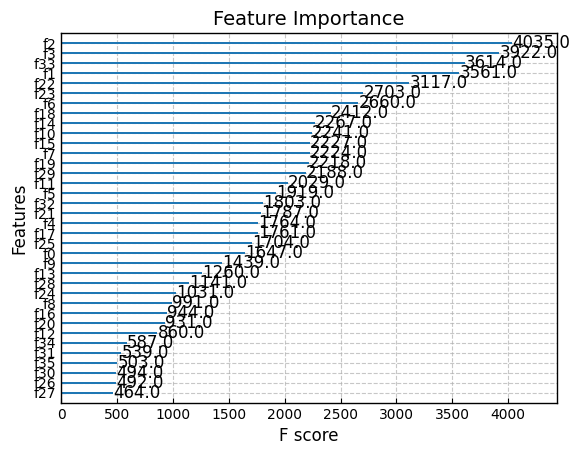

In [ ]:
# Plot feature importance
plt.figure(figsize=(10, 8))
plot_importance(xgb, importance_type='weight')  # Options: 'weight', 'gain', 'cover'
plt.title("Feature Importance")
plt.show()

### hyperparameter tuning xgboost using WandB

In [49]:
def convert_to_time_series_data_dynamic(input_df, window_size=5, features=['x', 'y', 'velocity', 'direction']):
    df = input_df.copy()
    # get unique combinations of subset, video, clip
    unique_combinations = df[['subset', 'video', 'clip']].drop_duplicates()
    rows = []

    for _, row in unique_combinations.iterrows():
        subset = row['subset']
        video = row['video']
        clip = row['clip']
        df_subset = df[(df['subset'] == subset) & (df['video'] == video) & (df['clip'] == clip)].sort_values(by='frame').reset_index(drop=True)

        for index, row in df_subset.iterrows():
            if index <= window_size or index > len(df_subset) - window_size:
                continue

            previous_frames = {}
            for i in range(window_size, 1, -1):
                lag_stamp = 'previous_' + str(i) + '_'
                for feature in features:
                    previous_frames[lag_stamp + feature] = df_subset.loc[index-i, feature]

            current_frame = {}
            for feature in features:
                current_frame[feature] = df_subset.loc[index, feature]

            future_frames = {}
            for i in range(1, window_size):
                lag_stamp = 'following_' + str(i) + '_'
                for feature in features:
                    future_frames[lag_stamp + feature] = df_subset.loc[index+i, feature]

            dict_trajectory = {"Flying":0, "Hit":1, "Bounce":2}

            if df_subset.loc[index, 'trajectory'] not in dict_trajectory:
                continue
            series = {
                'subset': subset,
                'video': video,
                'clip': clip,
                'frame': row['frame'],
                'trajectory': dict_trajectory[row['trajectory']],
                **current_frame,
                **previous_frames,
                **future_frames
            }
            rows.append(series)

    return pd.DataFrame(rows)

# training function
def train_XGBoost(df_train, df_val, config):
    n_estimators = config['n_estimators']
    learning_rate = config['learning_rate']
    max_depth = config['max_depth']
    subsample = config['subsample']
    window_size = config['window_size']
    balancing = config['Balancing']
    scaling = config['scaling']
    features = config['features']

    # Convert the data to time series
    df_train_time_series = convert_to_time_series_data_dynamic(df_train, window_size=window_size, features=features)
    df_val_time_series = convert_to_time_series_data_dynamic(df_val, window_size=window_size, features=features)

    # delete rows with missing values
    x_columns = features + ['previous_' + str(i) + '_' + feature for i in range(window_size, 1, -1) for feature in features] + ['following_' + str(i) + '_' + feature for i in range(1, window_size) for feature in features]
    allcolumns = x_columns + ['trajectory']
    df_train_time_series = df_train_time_series.dropna(subset=allcolumns)
    df_val_time_series = df_val_time_series.dropna(subset=allcolumns)

    # Split the data into X and y
    X_train = df_train_time_series[x_columns]
    y_train = df_train_time_series['trajectory']

    X_val = df_val_time_series[x_columns]
    y_val = df_val_time_series['trajectory']

    # Normalize the data if scaling is enabled
    if scaling:
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

    # If SMOTE is elected for balancing
    if balancing == 'SMOTE':
        smote = SMOTE(random_state=42)
        X_train, y_train = smote.fit_resample(X_train, y_train)
    
    #compute sample weight
    if balancing == 'weights':
        sample_weight = compute_sample_weight('balanced', y_train)
    else:
        sample_weight = compute_sample_weight(None, y_train)

    print (X_train.shape)
    print (y_train.shape)

    # Train an XGBoost classifier
    xgb = XGBClassifier(
        n_estimators=n_estimators,
        learning_rate=learning_rate,
        max_depth=max_depth,
        subsample=subsample,
        colsample_bytree=0.8, 
        random_state=42,
        use_label_encoder=False,
        objective='multi:softmax', 
        eval_metric='mlogloss',
        verbosity =0 
    )

    # Fit the model on the training data
    xgb.fit(X_train, y_train, verbose=False, sample_weight=sample_weight)

    # Predict on the validation set
    y_pred = xgb.predict(X_val)

    # Evaluate the model
    report_printable = classification_report(y_val, y_pred)
    report = classification_report(y_val, y_pred, output_dict=True)

    #confusion matrix
    cm = confusion_matrix(y_val, y_pred, normalize='true')

    return report, report_printable, xgb, cm


# Train the model
parameters = {
    "n_estimators": 300,
    "learning_rate": 0.1,
    "max_depth": 10,
    "subsample": 0.8,
    "window_size": 10,
    "scaling": True,
    "Balancing": "weights",
    "features": ['x', 'y', 'velocity', 'direction']
}

report, report_printable, model, cm = train_XGBoost(df_train, df_val, parameters)
# Print the classification report
print("Classification Report on Validation Set:")
print(report_printable)

(17409, 76)
(17409,)
Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3451
           1       0.66      0.45      0.54        86
           2       0.74      0.74      0.74        91

    accuracy                           0.97      3628
   macro avg       0.79      0.73      0.75      3628
weighted avg       0.97      0.97      0.97      3628



In [ ]:
report['macro avg']['f1-score']

0.7529174756579815

In [ ]:
sweep_config = {
    "method": "bayes", 
    "metric": {
        "name": "f1-score",
        "goal": "maximize"  
    },
    "parameters": {
        "n_estimators": {
            "values": [200, 300, 500]  # Number of trees in the ensemble
        },
        "learning_rate": {
            "min": 0.01,
            "max": 0.2  # Explore a range of learning rates
        },
        "max_depth": {
            "values": [5, 10, 15, 20]  # Depth of each tree
        },
        "subsample": {
            "values": [0.6, 0.8, 1.0]  # Fraction of samples used for training
        },
        "scaling": {
            "values": [True, False]  # Whether to normalize data
        },
        "Balancing": {
            "values": ["weights", "SMOTE", None]  # Balancing strategies
        },
        "window_size": {
            "values": [5, 7, 10]  # Different window sizes for the time-series data
        },
        "features": {
            "values": [['x', 'y'], ['x', 'y', 'velocity'], ['x', 'y', 'velocity', 'direction']]
        }
    }
}

def sweep_train(config=None):
    with wandb.init(config=config):
        # Access the sweep parameters
        config = wandb.config
        
        # Train the model
        report, report_printable, model, cm = train_XGBoost(
            df_train,
            df_val,
            config={
                "n_estimators": config.n_estimators,
                "learning_rate": config.learning_rate,
                "max_depth": config.max_depth,
                "subsample": config.subsample,
                "window_size": config.window_size,
                "scaling": config.scaling,
                "Balancing": config.Balancing,
                "features": config.features
            }
        )
        
        # log the classification report
        wandb.log(report)
        wandb.log({'f1-score': report['macro avg']['f1-score']})

# Initialize the sweep
sweep_id = wandb.sweep(sweep_config, project="XGBoost_Hyperparameter_Tuning")

# Start the sweep
#wandb.agent(sweep_id, function=sweep_train, count=100)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: videkg9h
Sweep URL: https://wandb.ai/MasterarbeitBV/XGBoost_Hyperparameter_Tuning/sweeps/videkg9h


## test sktime 

In [ ]:
from sktime.datasets import load_basic_motions

# load an example time series panel in numpy mtype
X, _ = load_basic_motions(return_type="numpy3D")
print(X.shape)
print(X[0].shape)
print(X[0][0].shape)

(80, 6, 100)
(6, 100)
(100,)


In [ ]:
def convert_df_to_numpy3d(df, features, sequence_length=21):
    # sequence length has to be odd to take the middle element as the target
    assert sequence_length % 2 == 1

    # get unique combinations of subset, video, clip
    unique_combinations = df[['subset', 'video', 'clip']].drop_duplicates()

    # create list to store numpy arrays
    X = []
    Y = []

    for _, row in unique_combinations.iterrows():
        subset = row['subset']
        video = row['video']
        clip = row['clip']
        df_subset = df[(df['subset'] == subset) & (df['video'] == video) & (df['clip'] == clip)].sort_values(by='frame').reset_index(drop=True)

        for index, row in df_subset.iterrows():
            #create two dimensional numpy array
            series = np.zeros((len(features), sequence_length))

            if index <= sequence_length or index > len(df_subset) - sequence_length:
                continue

            for i in range(sequence_length, 0, -1):
                for feature_idx, feature in enumerate(features):
                    series[feature_idx, sequence_length - i] = df_subset.loc[index-i, feature]

            # check if series or target is missing
            if np.isnan(series).any() or pd.isnull(df_subset.loc[index, 'trajectory']):
                continue
  
            X.append(series)
            trajectory_index = index - (sequence_length //2)
            Y.append(df_subset.loc[trajectory_index, 'trajectory'])

    return np.array(X), np.array(Y)

X_train, y_train = convert_df_to_numpy3d(df_train, ['x', 'y', 'slope', 'velocity'], sequence_length=11)
X_test, y_test = convert_df_to_numpy3d(df_test, ['x', 'y', 'slope', 'velocity'], sequence_length=11)
X_val, y_val = convert_df_to_numpy3d(df_val, ['x', 'y', 'slope', 'velocity'], sequence_length=11)

In [ ]:
print(X_train.shape)
print(X_train[0].shape)
print(X_train[0][0].shape)

(17819, 4, 11)
(4, 11)
(11,)


In [ ]:
# Assuming X_train is of shape (n_samples, n_timestamps, n_features)
n_samples, n_timestamps, n_features = X_train.shape

# Reshape for normalization: (total_instances, n_features)
X_train_reshaped = X_train.reshape(-1, n_features)

# Apply Standard Scaling
scaler = StandardScaler()
X_train_standardized = scaler.fit_transform(X_train_reshaped)

# Reshape back to original 3D shape
X_train_standardized = X_train_standardized.reshape(n_samples, n_timestamps, n_features)

In [ ]:
# Assume X_train is in shape (n_samples, n_timestamps, n_features)
n_samples, n_timestamps, n_features = X_train.shape

# Reshape into 2D array: (n_samples, n_timestamps * n_features)
X_train_flat = X_train.reshape(n_samples, n_timestamps * n_features)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled_flat, y_resampled = smote.fit_resample(X_train_flat, y_train)

# Calculate the new number of samples after resampling
n_resampled = X_resampled_flat.shape[0]

# Reshape back into (n_samples, n_timestamps, n_features)
X_resampled = X_resampled_flat.reshape(n_resampled, n_timestamps, n_features)

In [ ]:
print(X_resampled.shape)
print(X_resampled[0].shape)
print(X_resampled[0][0].shape)

(50796, 4, 11)
(4, 11)
(11,)


In [ ]:

clf_default = RocketClassifier(num_kernels=1000, random_state=42)
clf_default.fit(X_train, y_train)

y_pred = clf_default.predict(X_val)

# Evaluate the model
print("Classification Report on Test Set:")
print(classification_report(y_val, y_pred))

Classification Report on Test Set:
              precision    recall  f1-score   support

      Bounce       0.71      0.40      0.51        85
      Flying       0.97      0.99      0.98      3473
         Hit       0.72      0.32      0.45        90

    accuracy                           0.96      3648
   macro avg       0.80      0.57      0.65      3648
weighted avg       0.96      0.96      0.96      3648



## hyperparameter tuning sktime using wandb

In [48]:
def convert_df_to_numpy3d(df, features, sequence_length=21):
    # sequence length has to be odd to take the middle element as the target
    assert sequence_length % 2 == 1

    # get unique combinations of subset, video, clip
    unique_combinations = df[['subset', 'video', 'clip']].drop_duplicates()

    # create list to store numpy arrays
    X = []
    Y = []

    for _, row in unique_combinations.iterrows():
        subset = row['subset']
        video = row['video']
        clip = row['clip']
        df_subset = df[(df['subset'] == subset) & (df['video'] == video) & (df['clip'] == clip)].sort_values(by='frame').reset_index(drop=True)

        for index, row in df_subset.iterrows():
            #create two dimensional numpy array
            series = np.zeros((len(features), sequence_length))

            if index <= sequence_length or index > len(df_subset) - sequence_length:
                continue

            for i in range(sequence_length, 0, -1):
                for feature_idx, feature in enumerate(features):
                    series[feature_idx, sequence_length - i] = df_subset.loc[index-i, feature]

            # check if series or target is missing
            if np.isnan(series).any() or pd.isnull(df_subset.loc[index, 'trajectory']):
                continue
  
            X.append(series)
            trajectory_index = index - (sequence_length //2)
            Y.append(df_subset.loc[trajectory_index, 'trajectory'])

    return np.array(X), np.array(Y)


# training function
def train_ROCKET(df_train, df_val, config):
    num_kernels = config['num_kernels']
    n_features_per_kernel = config['n_features_per_kernel']
    rocket_transform = config['rocket_transform']
    window_size = config['window_size']
    balancing = config['Balancing']
    scaling = config['scaling']
    features = config['features']

    # convert data to numpy3D
    X_train, y_train = convert_df_to_numpy3d(df_train, features, sequence_length=window_size)
    X_val, y_val = convert_df_to_numpy3d(df_val, features, sequence_length=window_size)

    # Normalize the data if scaling is enabled
    if scaling:
        # Reshape for normalization: (total_instances, n_features)
        n_samples, n_timestamps, n_features = X_train.shape
        X_train_reshaped = X_train.reshape(-1, n_features)
        scaler = StandardScaler()
        X_train_standardized = scaler.fit_transform(X_train_reshaped)
        X_train = X_train_standardized.reshape(n_samples, n_timestamps, n_features)

        # Normalize the validation set
        n_samples, n_timestamps, n_features = X_val.shape
        X_val_reshaped = X_val.reshape(-1, n_features)
        X_val_standardized = scaler.transform(X_val_reshaped)
        X_val = X_val_standardized.reshape(n_samples, n_timestamps, n_features)

    # Blanace the data if SMOTE is enabled
    if balancing:
        n_samples, n_timestamps, n_features = X_train.shape
        X_train_flat = X_train.reshape(n_samples, n_timestamps * n_features)
        smote = SMOTE(random_state=42)
        X_resampled_flat, y_train = smote.fit_resample(X_train_flat, y_train)
        n_resampled = X_resampled_flat.shape[0]
        X_train = X_resampled_flat.reshape(n_resampled, n_timestamps, n_features)

    # Train the model
    clf = RocketClassifier(num_kernels=num_kernels, n_features_per_kernel=n_features_per_kernel,rocket_transform=rocket_transform , random_state=42, n_jobs=1)

    clf.fit(X_train, y_train)

    # Predict on the validation set
    y_pred = clf.predict(X_val)

    # Evaluate the model
    report = classification_report(y_val, y_pred, output_dict=True)
    report_printable = classification_report(y_val, y_pred)

    #confusion matrix
    cm = confusion_matrix(y_val, y_pred, normalize='true')

    return report, report_printable, clf, cm 


# Train the model
parameters = {
    "num_kernels": 500,
    "n_features_per_kernel": 4,
    "rocket_transform": "rocket",
    "window_size": 11,
    "scaling": True,
    "Balancing": False,
    "features": ['x', 'y']
}

report, report_printable, model, cm = train_ROCKET(df_train, df_val, parameters)
print("Classification Report on Validation Set:")
print(report_printable)

Classification Report on Validation Set:
              precision    recall  f1-score   support

      Bounce       0.77      0.48      0.59        85
      Flying       0.97      0.99      0.98      3473
         Hit       0.68      0.36      0.47        90

    accuracy                           0.97      3648
   macro avg       0.81      0.61      0.68      3648
weighted avg       0.96      0.97      0.96      3648



In [ ]:
sweep_config = {
    "method": "bayes", 
    "metric": {
        "name": "f1-score",
        "goal": "maximize"  
    },
    "parameters": {
        "num_kernels": {
            "values": [500, 1000, 2000]  
        },
        "n_features_per_kernel": {
            "values": [2, 4] 
        },
        "rocket_transform": {
            "values": ["rocket"]  
        },
        "scaling": {
            "values": [True, False]  # Whether to normalize data
        },
        "Balancing": {
            "values": [True, False]  # Balancing strategies
        },
        "window_size": {
            "values": [7, 11, 21]  # Different window sizes for the time-series data
        },
        "features": {
            "values": [['x', 'y'], ['x', 'y', 'velocity'], ['x', 'y', 'velocity', 'direction']]
        }
    }
}

def sweep_train_ROCKET(config=None):
    with wandb.init(config=config):
        # Access the sweep parameters
        config = wandb.config
        
        # Train the model
        report, report_printable, model, cm = train_ROCKET(
            df_train,
            df_val,
            config={
                "num_kernels": config.num_kernels,
                "n_features_per_kernel": config.n_features_per_kernel,
                "rocket_transform": config.rocket_transform,
                "window_size": config.window_size,
                "scaling": config.scaling,
                "Balancing": config.Balancing,
                "features": config.features
            }
        )
        
        # log the classification report
        wandb.log(report)
        wandb.log({'f1-score': report['macro avg']['f1-score']})
  

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: oros33fx
Sweep URL: https://wandb.ai/MasterarbeitBV/XGBoost_Hyperparameter_Tuning/sweeps/oros33fx


wandb: Agent Starting Run: bfc1up7g with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11
wandb: Currently logged in as: spleedy (MasterarbeitBV). Use `wandb login --relogin` to force relogin


accuracy,▁
f1-score,▁
accuracy,0.91996
f1-score,0.65816


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yosv1b2o with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.92133
f1-score,0.66657


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: piyzud1g with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96546
f1-score,0.68472


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ccpb8jze with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.92749
f1-score,0.67429


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 01boeghh with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.9649
f1-score,0.66625


wandb: Agent Starting Run: votiba2o with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.95926
f1-score,0.58352


wandb: Agent Starting Run: fsl1tnd9 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.89008
f1-score,0.60078


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6rqqosyt with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 1000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95482
f1-score,0.44313


wandb: Agent Starting Run: n5p54lcy with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.89008
f1-score,0.60078


wandb: Agent Starting Run: kr1h2rqb with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 1000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93147
f1-score,0.69138


wandb: Agent Starting Run: 2emb5nru with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96683
f1-score,0.70695


wandb: Agent Starting Run: 6pnbgtoi with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 1000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.91707
f1-score,0.66355


wandb: Agent Starting Run: e5klhro8 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: g0m7sn09 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: b865ewhr with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93942
f1-score,0.70799


wandb: Agent Starting Run: vh9wut1k with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95579
f1-score,0.50094


wandb: Agent Starting Run: 7wnj3kw5 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.88738
f1-score,0.60434


wandb: Agent Starting Run: a06fe7yr with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.94463
f1-score,0.71883


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: wxrfy7nv with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.9649
f1-score,0.66625


wandb: Agent Starting Run: asbljf3p with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96546
f1-score,0.68472


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 128fsxdt with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95547
f1-score,0.46522


wandb: Agent Starting Run: mdot0rob with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.89416
f1-score,0.62271


wandb: Agent Starting Run: beg4zdpt with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 1000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95708
f1-score,0.52077


wandb: Agent Starting Run: c1x8jknw with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.9649
f1-score,0.66625


wandb: Agent Starting Run: vc42vxg3 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96573
f1-score,0.69926


wandb: Agent Starting Run: xfup2olq with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: h6ens5kg with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.9232
f1-score,0.67739


wandb: Agent Starting Run: 56kdabyx with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: l62z4xmt with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Agent Starting Run: wl9es4gl with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: 24kwnte2 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: 2sdid3jm with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95547
f1-score,0.46411


wandb: Agent Starting Run: 14y19444 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9386
f1-score,0.70736


wandb: Agent Starting Run: gcf32962 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.96387
f1-score,0.68542


wandb: Agent Starting Run: 6gokg9er with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: q0otvog6 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: ifo62zr2 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96711
f1-score,0.71808


wandb: Agent Starting Run: wir8mslh with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96683
f1-score,0.70695


wandb: Agent Starting Run: ou6bj3kw with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: c4a403ck with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: irqfkbcl with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96711
f1-score,0.71808


wandb: Agent Starting Run: odt4t1g8 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: e9k1xz7u with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Agent Starting Run: n6weouwa with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: pmbicquq with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96711
f1-score,0.71808


wandb: Agent Starting Run: awc1vr87 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: qwurzhe3 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Agent Starting Run: k3cfbcg2 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 94ysmwbi with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: y0eysdrc with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: jdzyr589 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: q3ews9k6 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93942
f1-score,0.70799


wandb: Agent Starting Run: igfe09jp with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9386
f1-score,0.70736


wandb: Agent Starting Run: t9j91crx with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: 02fjqyeh with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: x210uohe with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: wio30yz8 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72626


wandb: Agent Starting Run: 6csdaa7t with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.91417
f1-score,0.6506


wandb: Agent Starting Run: 6ty1wqml with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 1000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.92083
f1-score,0.65999


wandb: Agent Starting Run: lrf2gpo1 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 500
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.90238
f1-score,0.62462


wandb: Agent Starting Run: 5glabo3k with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.92288
f1-score,0.66206


wandb: Agent Starting Run: 1s2cfkl6 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y', 'velocity']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93942
f1-score,0.70799


wandb: Agent Starting Run: rgo0auz5 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.96387
f1-score,0.68542


wandb: Agent Starting Run: 9oudw2tl with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.96644
f1-score,0.69938


wandb: Agent Starting Run: gw01c5pw with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y', 'velocity', 'direction']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96573
f1-score,0.69926


wandb: Agent Starting Run: 4tybf0lj with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 7


accuracy,▁
f1-score,▁
accuracy,0.96387
f1-score,0.68542


wandb: Agent Starting Run: cdqzk639 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: ojysnsas with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95547
f1-score,0.46411


wandb: Agent Starting Run: vagqm32m with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: a0npxss3 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: ec50sdjg with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 21mdfh24 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95515
f1-score,0.45567


wandb: Agent Starting Run: ewykqvbq with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.9232
f1-score,0.67739


wandb: Agent Starting Run: wlrb7doh with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95547
f1-score,0.46411


wandb: Agent Starting Run: a0igvars with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: tue3563j with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: suvk14xf with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d8cbix4o with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.9232
f1-score,0.67739


wandb: Agent Starting Run: o47s5aiy with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: brmrkg69 with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Agent Starting Run: d1uxmb4x with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: jyvm8fy0 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: f0ptj2ju with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: 7p3ok05z with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: yuk6nkek with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: 3v0l76ug with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.9232
f1-score,0.67739


wandb: Agent Starting Run: gc4pixk0 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95515
f1-score,0.45567


wandb: Agent Starting Run: o835b5pj with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: q66slvcb with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: 0274lvcl with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: o8shg6ju with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: z5dtft9g with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r3yfoluh with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


wandb: Agent Starting Run: xhj97r08 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.95515
f1-score,0.45567


wandb: Agent Starting Run: lgqybryp with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: 3deyitup with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 21


accuracy,▁
f1-score,▁
accuracy,0.92062
f1-score,0.6691


wandb: Agent Starting Run: wb1q960o with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93777
f1-score,0.70348


wandb: Agent Starting Run: 2wj56pus with config:
wandb: 	Balancing: True
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 2
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.93914
f1-score,0.70994


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: y013iwm5 with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: False
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.9682
f1-score,0.72409


wandb: Agent Starting Run: mut04wls with config:
wandb: 	Balancing: False
wandb: 	features: ['x', 'y']
wandb: 	n_features_per_kernel: 4
wandb: 	num_kernels: 2000
wandb: 	rocket_transform: rocket
wandb: 	scaling: True
wandb: 	window_size: 11


accuracy,▁
f1-score,▁
accuracy,0.96875
f1-score,0.72909


## Test Results

Generate test results for both models

In [67]:
# XGBOOST

# Train the model
parameters = {
    "n_estimators": 200,
    "learning_rate": 0.1849,
    "max_depth": 15,
    "subsample": 1,
    "window_size": 10,
    "scaling": True,
    "Balancing": "SMOTE",
    "features": ['x', 'y', 'velocity', 'direction']
}

report_xgboost, report_printable_xgboost, model_xgboost, cm_xgboost= train_XGBoost(df_train, df_test, parameters)
# Print the classification report
print("Classification Report on Test Set:")
print(report_printable_xgboost)

(49572, 76)
(49572,)
Classification Report on Test Set:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      3311
           1       0.54      0.47      0.51        78
           2       0.70      0.72      0.71        95

    accuracy                           0.96      3484
   macro avg       0.74      0.72      0.73      3484
weighted avg       0.96      0.96      0.96      3484



In [ ]:
# results multirocket

# Train the model
parameters = {
    "num_kernels": 1500,
    "n_features_per_kernel": 4,
    "rocket_transform": "multirocket",
    "window_size": 11,
    "scaling": True,
    "Balancing": False,
    "features": ['x', 'y']
}

report_multirocket, report_printable_multirocket, model_multirocket, cm_multi = train_ROCKET(df_train, df_test, parameters)
print("Classification Report on Test Set:")
print(report_printable_multirocket)

Classification Report on Test Set:
              precision    recall  f1-score   support

      Bounce       0.73      0.66      0.69        89
      Flying       0.98      0.99      0.98      3383
         Hit       0.64      0.27      0.38        85

    accuracy                           0.97      3557
   macro avg       0.78      0.64      0.69      3557
weighted avg       0.96      0.97      0.96      3557



In [68]:
# results rocket

# Train the model
parameters = {
    "num_kernels": 2000,
    "n_features_per_kernel": 2,
    "rocket_transform": "rocket",
    "window_size": 11,
    "scaling": True,
    "Balancing": False,
    "features": ['x', 'y']
}

report_rocket, report_printable_rocket, model_rocket, cm_rocket = train_ROCKET(df_train, df_test, parameters)
print("Classification Report on Test Set:")
print(report_printable_rocket)

Classification Report on Test Set:
              precision    recall  f1-score   support

      Bounce       0.81      0.73      0.77        89
      Flying       0.98      0.99      0.99      3383
         Hit       0.68      0.27      0.39        85

    accuracy                           0.97      3557
   macro avg       0.82      0.66      0.71      3557
weighted avg       0.97      0.97      0.97      3557



In [23]:
# save the models
import joblib

joblib.dump(model_xgboost, 'BounceHit_best_xgboost.pkl')
joblib.dump(model_multirocket, 'BounceHit_best_multirocket.pkl')
joblib.dump(model_rocket, 'BounceHit_best_rocket.pkl')

['BounceHit_best_rocket.pkl']

In [34]:
# combine reports into a dataframe
report_xgboost['model'] = 'XGBoost'
report_multirocket['model'] = 'MultiRocket'
report_rocket['model'] = 'Rocket'

# convert labels back for xgboost
dict_trajectory = {"0":"Flying", "1":"Hit", "2":"Bounce"}

# replace keys
new = {}
for key, value in report_xgboost.items():
    if key in dict_trajectory:
        new[dict_trajectory[key]] = value
    else:
        new[key] = value

report_xgboost = new

#print reports
print(report_xgboost)
print(report_multirocket)
print(report_rocket)

{'Flying': {'precision': 0.9813196746007834, 'recall': 0.9836907278767744, 'f1-score': 0.9825037707390648, 'support': 3311.0}, 'Hit': {'precision': 0.5441176470588235, 'recall': 0.47435897435897434, 'f1-score': 0.5068493150684932, 'support': 78.0}, 'Bounce': {'precision': 0.7010309278350515, 'recall': 0.7157894736842105, 'f1-score': 0.7083333333333334, 'support': 95.0}, 'accuracy': 0.9649827784156142, 'macro avg': {'precision': 0.7421560831648861, 'recall': 0.7246130586399864, 'f1-score': 0.7325621397136305, 'support': 3484.0}, 'weighted avg': {'precision': 0.9638887936906176, 'recall': 0.9649827784156142, 'f1-score': 0.9643788456254456, 'support': 3484.0}, 'model': 'XGBoost'}
{'Bounce': {'precision': 0.7283950617283951, 'recall': 0.6629213483146067, 'f1-score': 0.6941176470588235, 'support': 89.0}, 'Flying': {'precision': 0.9761627906976744, 'recall': 0.9926101093703813, 'f1-score': 0.9843177487908544, 'support': 3383.0}, 'Hit': {'precision': 0.6388888888888888, 'recall': 0.2705882352

In [45]:
# Conversion process
results = []
for report in [report_xgboost, report_rocket]:
    model_name = report['model']
    for class_label, metrics in report.items():
        if class_label == "model" or class_label == "accuracy" or  class_label == "weighted avg":
            continue
        results.append({
            "model": model_name,
            "class": class_label if class_label != "macro avg" else "Total",
            "precision": metrics.get("precision"),
            "recall": metrics.get("recall"),
            "f1": metrics.get("f1-score"),
            "support": metrics.get("support"),
        })

results = pd.DataFrame(results)
# sort by model and class
results = results.sort_values(by=['class', 'model']).reset_index(drop=True)
results

,model,class,precision,recall,f1,support
0,Rocket,Bounce,0.812500,0.730337,0.769231,89.0
1,XGBoost,Bounce,0.701031,0.715789,0.708333,95.0
2,Rocket,Flying,0.976474,0.993792,0.985057,3383.0
3,XGBoost,Flying,0.981320,0.983691,0.982504,3311.0
4,Rocket,Hit,0.676471,0.270588,0.386555,85.0
5,XGBoost,Hit,0.544118,0.474359,0.506849,78.0
6,Rocket,Total,0.821815,0.664906,0.713614,3557.0
7,XGBoost,Total,0.742156,0.724613,0.732562,3484.0


In [75]:
cm_rocket

array([[0.73033708, 0.26966292, 0.        ],
       [0.00295596, 0.99379249, 0.00325155],
       [0.05882353, 0.67058824, 0.27058824]])

C:\Users\benev\AppData\Local\Temp\ipykernel_19656\2065307135.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


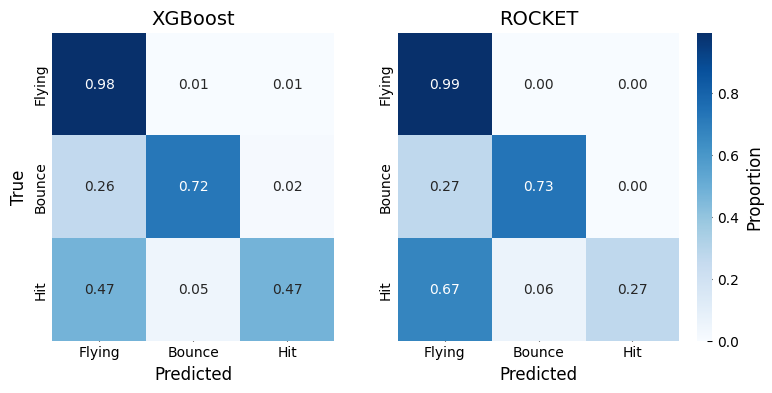

In [92]:
set_plot_style_default()

def plot_two_confusion_matrices_from_df(cm1, cm2, model_names, cmap='Blues'):
    # Create the figure and axes
    fig, axes = plt.subplots(1, 2, figsize=(9, 4), gridspec_kw={'width_ratios': [1, 1.25], 'wspace': 0.2})

    # Heatmap for the first model
    sns.heatmap(cm1, annot=True, fmt='.2f', cmap=cmap, cbar=False, ax=axes[0], annot_kws={"size": 10})
    axes[0].set_title(model_names[0])
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('True')

    # Heatmap for the second model
    sns.heatmap(cm2, annot=True, fmt='.2f', cmap=cmap, cbar=True, ax=axes[1],
                cbar_kws={'label': 'Proportion'}, annot_kws={"size": 10})
    axes[1].set_title(model_names[1])
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel(' ')  # Remove y-axis labels for the second heatmap

    plt.tight_layout()
    plt.show()

# convert cm to dataframe
cm_xgboost_df = pd.DataFrame(cm_xgboost, columns=['Flying', 'Hit', 'Bounce'], index=['Flying', 'Hit', 'Bounce'])
cm_rocket_df = pd.DataFrame(cm_rocket, columns=['Bounce', 'Flying', 'Hit'], index=['Bounce', 'Flying', 'Hit'])

# reorder rows and columns to match
cm_xgboost_df = cm_xgboost_df[['Flying', 'Bounce', 'Hit']]
cm_xgboost_df = cm_xgboost_df.reindex(['Flying', 'Bounce', 'Hit'])

# reorder rows and columns to match
cm_rocket_df = cm_rocket_df[['Flying', 'Bounce', 'Hit']]
cm_rocket_df = cm_rocket_df.reindex(['Flying', 'Bounce', 'Hit'])

# Plot the confusion matrix
plot_two_confusion_matrices_from_df(cm_xgboost_df, cm_rocket_df, ['XGBoost', 'ROCKET'])
